### Part 2: Sentiment Classification using CNN and BERT embeddings

In [126]:
# importing important libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import re
import string
import nltk
import time
import textblob
import torch
import torch.nn as nn
import transformers as ppb
from textblob import TextBlob
import torch.nn.functional as F
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from torch.autograd import Variable
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_score, recall_score, f1_score

# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# importing the necessary packages from nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
# Loading the data
data = pd.read_csv('Womens Clothing E-Commerce Reviews.csv', index_col = [0])
data.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [5]:
# checking the shape of the dataset
data.shape

(23486, 10)

In [6]:
# Let's keep only Title, Review Text and Rating columns as only those are required in this study
data_df = data[['Title', 'Review Text', 'Rating']]
data_df.head()

,Title,Review Text,Rating
0,NaN,Absolutely wonderful - silky and sexy and comf...,4
1,NaN,Love this dress! it's sooo pretty. i happene...,5
2,Some major design flaws,I had such high hopes for this dress and reall...,3
3,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5
4,Flattering shirt,This shirt is very flattering to all due to th...,5


In [7]:
# Let's check the missing values
data_df.isnull().sum()/len(data_df)*100

Title          16.222430
Review Text     3.597888
Rating          0.000000
dtype: float64

In [8]:
# drop rows where there is no review given by the customer
data_df = data_df[~data_df['Review Text'].isnull()]
data_df.shape

(22641, 3)

In [9]:
# Let's check the rows where title is missing
data_df.loc[data_df['Title'].isnull()].head()

,Title,Review Text,Rating
0,NaN,Absolutely wonderful - silky and sexy and comf...,4
1,NaN,Love this dress! it's sooo pretty. i happene...,5
11,NaN,This dress is perfection! so pretty and flatte...,5
30,NaN,Beautifully made pants and on trend with the f...,5
36,NaN,This is a comfortable skirt that can span seas...,4


In [10]:
# Generating a new column 'Review' by clubbing together columns 'Title' and 'Review Text' if the Title column is not blank
# otherwise keeping only the 'Review Text' column value
data_df['Review'] = np.where(data_df['Title'].isnull(), data_df['Review Text'], data_df['Title'] + ' ' + data_df['Review Text'])
data_df.head()

,Title,Review Text,Rating,Review
0,NaN,Absolutely wonderful - silky and sexy and comf...,4,Absolutely wonderful - silky and sexy and comf...
1,NaN,Love this dress! it's sooo pretty. i happene...,5,Love this dress! it's sooo pretty. i happene...
2,Some major design flaws,I had such high hopes for this dress and reall...,3,Some major design flaws I had such high hopes ...
3,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,"My favorite buy! I love, love, love this jumps..."
4,Flattering shirt,This shirt is very flattering to all due to th...,5,Flattering shirt This shirt is very flattering...


In [11]:
# dropping the 'Title' and 'Review Text' columns
data_df = data_df.drop(['Title', 'Review Text'], axis=1)
data_df.head()

,Rating,Review
0,4,Absolutely wonderful - silky and sexy and comf...
1,5,Love this dress! it's sooo pretty. i happene...
2,3,Some major design flaws I had such high hopes ...
3,5,"My favorite buy! I love, love, love this jumps..."
4,5,Flattering shirt This shirt is very flattering...


In [12]:
# Let's check the shape again
data_df.shape

(22641, 2)

In [13]:
# Let's create a new column capturing the type of sentiment of the review as positive or negative. Map rating of 4 and 5 as
# positive and ratings less than equal to 3 as negative as we are handling binary sentiment classification here.
data_df['Sentiment'] = np.where(data_df['Rating']>3, 'Positive', 'Negative')
data_df.head()

,Rating,Review,Sentiment
0,4,Absolutely wonderful - silky and sexy and comf...,Positive
1,5,Love this dress! it's sooo pretty. i happene...,Positive
2,3,Some major design flaws I had such high hopes ...,Negative
3,5,"My favorite buy! I love, love, love this jumps...",Positive
4,5,Flattering shirt This shirt is very flattering...,Positive


In [14]:
# Mapping the categorical text to numeric or binary i.e. 1 for Positive and 0 for Negative
sentiment_type = {"Positive": 1, "Negative": 0}
data_df['Sentiment'] = data_df['Sentiment'].map(sentiment_type)
data_df.head()

,Rating,Review,Sentiment
0,4,Absolutely wonderful - silky and sexy and comf...,1
1,5,Love this dress! it's sooo pretty. i happene...,1
2,3,Some major design flaws I had such high hopes ...,0
3,5,"My favorite buy! I love, love, love this jumps...",1
4,5,Flattering shirt This shirt is very flattering...,1


In [15]:
# Let's check the unique values and their frequency in the Rating column
data_df['Rating'].value_counts()

5    12540
4     4908
3     2823
2     1549
1      821
Name: Rating, dtype: int64

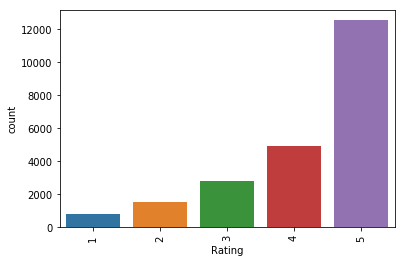

In [16]:
# Let's visualise and see
sns.countplot(x='Rating', data=data_df)
plt.xticks(rotation='vertical')
plt.show()

Data looks imbalanced as maximum are positive reviews i.e. with rating 4 and 5. Considering Rating <= 3 as negative and > 3 as positive. Let's randomly take 1000 reviews with rating 5, 1000 reviews with rating 4 and around 666 or 667 reviews with rating 1, 2 and 3 to make the data more balanced.

In [82]:
# Random sampling of records to make the distribution balanced
data_df5 = data_df[data_df['Rating'] == 5].sample(n=1000)
data_df4 = data_df[data_df['Rating'] == 4].sample(n=1000)
data_df3 = data_df[data_df['Rating'] == 3].sample(n=666)
data_df2 = data_df[data_df['Rating'] == 2].sample(n=667)
data_df1 = data_df[data_df['Rating'] == 1].sample(n=667)
data_final = pd.concat([data_df5, data_df4, data_df3, data_df2, data_df1])
data_final = data_final.sample(frac=1)
data_final.shape

(4000, 3)

In [83]:
# Let's view the new dataframe once
data_final.head()

,Rating,Review,Sentiment
477,5,Very cute jacket! I took a chance and tried on...,1
1132,4,Cute but runs small This dress is attractive b...,1
4940,5,"Worth the regular price! Amazingly soft, thin ...",1
19802,1,This skirt has no closure along the slit. i ca...,0
23205,2,Unimpressed I was so excited for this kimono. ...,0


In [84]:
# Let's check the dataframe info once
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 477 to 10237
Data columns (total 3 columns):
Rating       4000 non-null int64
Review       4000 non-null object
Sentiment    4000 non-null int64
dtypes: int64(2), object(1)
memory usage: 125.0+ KB


In [85]:
# TEXT CLEANING USING TextBlob spellchecker
# Text cleaning i.e. removal of punctuation marks, tokenization and conversion to lowercase

def text_cleaning(original_str):
    tokens = word_tokenize(original_str)
    clean_list1 = [word.lower() for word in tokens if word.isalpha()]
    clean_list = [''.join(TextBlob(word).correct()) if not wordnet.synsets(word) else word for word in clean_list1 ]
    clean_str = ' '.join(clean_list)
    return clean_str

In [86]:
# Applying text_cleaning function to Review column
data_final['Review'] = data_final['Review'].apply(text_cleaning)
data_final['Review'].head()

477      very cute jacket i took a chance and tried on ...
1132     cute but runs small this dress is attractive b...
4940     worth the regular price amazingly soft thin an...
19802    this skirt has no closure along the slit i ca ...
23205    unimpressed i was so excited for this kimono i...
Name: Review, dtype: object

In [87]:
# Loading BERT model and tokenizer class
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [88]:
# Split the dataset into training with 2800 reviews, validation set for checking the accuracy during training and testing set
# after the training
train_df = data_final[:2800].reset_index(drop=True)
val_df = data_final[2800:3200].reset_index(drop=True)
test_df = data_final[3200:4000].reset_index(drop=True)

In [89]:
# select the target column
target_column = ["Sentiment"]

In [90]:
# tokenize and find the max_len of words in a review
tokenized = data_final['Review'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

In [91]:
# let's print the max_len
max_len

122

In [92]:
# defining functions for tokenizing and padding
def tokenize_review(df, max_len):
    return [
        tokenizer.encode(text, add_special_tokens=True)[:max_len] for text in df['Review'].values
    ]
def pad_review(tokenized_text, max_len):
    return np.array([el + [0] * (max_len - len(el)) for el in tokenized_text])

In [93]:
# defining functions to invoke tokenising, padding functions and for converting to tensors
def tokenize_and_pad_review(df, max_len):
    tokenized = tokenize_review(df, max_len)
    padded = pad_review(tokenized, max_len)
    return torch.tensor(padded)
def convert_to_tensor(df, target_columns):
    return torch.tensor(df[target_columns].values, dtype=torch.float32)

In [94]:
# tokenize, pad and convert reviews to PyTorch tensors and then transform the text to embeddings

train_ids = tokenize_and_pad_review(train_df, max_len)
val_ids = tokenize_and_pad_review(val_df, max_len)
test_ids = tokenize_and_pad_review(test_df, max_len)

with torch.no_grad():
    train_x = model(train_ids)[0]  
    val_x = model(val_ids)[0]
    test_x = model(test_ids)[0]

train_y = convert_to_tensor(train_df, target_column)
val_y = convert_to_tensor(val_df, target_column)
test_y = convert_to_tensor(test_df, target_column)

In [95]:
# Let's see the first comment
train_x[0]

tensor([[ 0.1047,  0.0072,  0.4617,  ..., -0.0353,  0.3034,  0.1227],
        [ 0.3074, -0.1533,  0.3883,  ..., -0.6510,  0.0213,  0.1726],
        [-0.5532, -0.5417,  0.3376,  ..., -0.4726,  0.4474, -0.9299],
        ...,
        [ 0.1454, -0.2829,  1.1315,  ..., -0.3933,  0.3932, -0.9648],
        [ 0.2307, -0.3189,  1.0602,  ..., -0.3744,  0.3886, -0.9407],
        [-0.0019, -0.0868,  0.3539,  ..., -0.4053,  0.1200, -0.6772]])

In [96]:
# The KimCNN model
class KimCNN(nn.Module):
    def __init__(self, embed_num, embed_dim, class_num, kernel_num, kernel_sizes, dropout, static):
        super(KimCNN, self).__init__()
        V = embed_num
        D = embed_dim
        C = class_num
        Co = kernel_num
        Ks = kernel_sizes
        
        self.static = static
        self.embed = nn.Embedding(V, D)
        self.convs1 = nn.ModuleList([nn.Conv2d(1, Co, (K, D)) for K in Ks])
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(len(Ks) * Co, C)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        if self.static:
            x = Variable(x)
        x = x.unsqueeze(1)  # (N, Ci, W, D)
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1]  # [(N, Co, W), ...]*len(Ks)
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  # [(N, Co), ...]*len(Ks)
        x = torch.cat(x, 1)
        x = self.dropout(x)  # (N, len(Ks)*Co)
        logit = self.fc1(x)  # (N, C)
        output = self.sigmoid(logit)
        return output

In [97]:
# Training parameters
embed_num = train_x.shape[1]
embed_dim = train_x.shape[2]
class_num = train_y.shape[1]
kernel_num = 3
kernel_sizes = [2, 3, 4]
dropout = 0.5
static = True
model = KimCNN(
    embed_num=embed_num,
    embed_dim=embed_dim,
    class_num=class_num,
    kernel_num=kernel_num,
    kernel_sizes=kernel_sizes,
    dropout=dropout,
    static=static,
)

In [98]:
# train n_epochs, batch_size etc
n_epochs = 10
batch_size = 10
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.BCELoss()

In [99]:
# generate batches of data for training
def generate_batch_data(x, y, batch_size):
    i, batch = 0, 0
    for batch, i in enumerate(range(0, len(x) - batch_size, batch_size), 1):
        x_batch = x[i : i + batch_size]
        y_batch = y[i : i + batch_size]
        yield x_batch, y_batch, batch
    if i + batch_size < len(x):
        yield x[i + batch_size :], y[i + batch_size :], batch + 1
    if batch == 0:
        yield x, y, 1

In [100]:
# Let's train the model
train_losses, val_losses = [], []

for epoch in range(n_epochs):
    start_time = time.time()
    train_loss = 0

    model.train(True)
    for x_batch, y_batch, batch in generate_batch_data(train_x, train_y, batch_size):
        y_pred = model(x_batch)
        optimizer.zero_grad()
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= batch
    train_losses.append(train_loss)
    elapsed = time.time() - start_time

    model.eval() # disable dropout for deterministic output
    with torch.no_grad(): # deactivate autograd engine to reduce memory usage and speed up computations
        val_loss, batch = 0, 1
        for x_batch, y_batch, batch in generate_batch_data(val_x, val_y, batch_size):
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)
            val_loss += loss.item()
        val_loss /= batch
        val_losses.append(val_loss)

    print(
        "Epoch %d Train loss: %.2f. Validation loss: %.2f. Elapsed time: %.2fs."
        % (epoch + 1, train_losses[-1], val_losses[-1], elapsed)
    )

Epoch 1 Train loss: 0.63. Validation loss: 0.52. Elapsed time: 8.82s.
Epoch 2 Train loss: 0.52. Validation loss: 0.41. Elapsed time: 8.88s.
Epoch 3 Train loss: 0.47. Validation loss: 0.41. Elapsed time: 8.75s.
Epoch 4 Train loss: 0.44. Validation loss: 0.40. Elapsed time: 8.86s.
Epoch 5 Train loss: 0.42. Validation loss: 0.36. Elapsed time: 8.73s.
Epoch 6 Train loss: 0.41. Validation loss: 0.38. Elapsed time: 8.94s.
Epoch 7 Train loss: 0.42. Validation loss: 0.39. Elapsed time: 8.81s.
Epoch 8 Train loss: 0.38. Validation loss: 0.37. Elapsed time: 9.17s.
Epoch 9 Train loss: 0.37. Validation loss: 0.36. Elapsed time: 8.89s.
Epoch 10 Train loss: 0.37. Validation loss: 0.36. Elapsed time: 8.94s.


Text(0.5,1,'Losses')

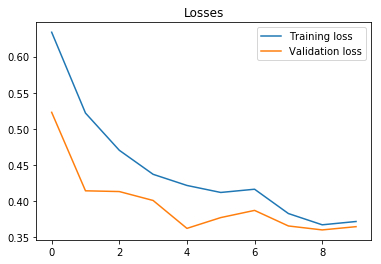

In [101]:
# Plotting the training and validation losses
plt.plot(train_losses, label="Training loss")
plt.plot(val_losses, label="Validation loss")
plt.legend()
plt.title("Losses")

The training and validation losses start converging after 8 epochs as can be seen from the above plot.

In [103]:
# Predict the labels for test set
# Let's disable dropout for deterministic output
model.eval()
with torch.no_grad(): # to reduce memory usage and seep up computations, let's deactivate autograd engine
    y_preds = []
    batch = 0
    for x_batch, y_batch, batch in generate_batch_data(test_x, test_y, batch_size):
        y_pred = model(x_batch)
        y_preds.extend(y_pred.cpu().numpy().tolist())
    y_preds_np = np.array(y_preds)

In [104]:
y_pred_final = pd.DataFrame(y_preds_np, columns=['Sentiment_prob'])
y_pred_final['Sentiment_pred'] = y_pred_final.Sentiment_prob.map(lambda x: 1 if x > 0.5 else 0)

# Let's see the head
y_pred_final.head()

,Sentiment_prob,Sentiment_pred
0,0.997312,1
1,0.275064,0
2,0.982931,1
3,0.336628,0
4,0.825437,1


In [106]:
# Real labels
y_test_np = test_df[target_column].values
y_test_np[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1]])

In [112]:
# Define function for plotting ROC curve
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

Confusion Matrix: 
 [[335  70]
 [ 44 351]]
Classification Matrix: 
              precision    recall  f1-score   support

          0       0.88      0.83      0.85       405
          1       0.83      0.89      0.86       395

avg / total       0.86      0.86      0.86       800

Accuracy:  0.86
Precision Score:  0.83
Recall Score:  0.89
F1 Score:  0.86
AUC_ROC:  0.93


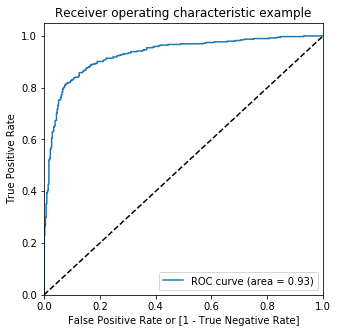

In [128]:
# Print classification report and other scores. Plot th roc curve as well.
print("Confusion Matrix: \n", confusion_matrix(y_test_np,y_pred_final['Sentiment_pred']))
print("Classification Matrix: \n", classification_report(y_test_np, y_pred_final['Sentiment_pred']))
print("Accuracy: ", round(accuracy_score(y_test_np, y_pred_final['Sentiment_pred']),2))
print("Precision Score: ", round(precision_score(y_test_np, y_pred_final['Sentiment_pred']),2))
print("Recall Score: ", round(recall_score(y_test_np, y_pred_final['Sentiment_pred']),2))
print("F1 Score: ", round(f1_score(y_test_np, y_pred_final['Sentiment_pred']),2))
print("AUC_ROC: ", round(roc_auc_score(y_test_np, y_preds_np, average=None),2))
draw_roc(y_test_np,y_pred_final['Sentiment_prob'])

**Conclusion derived from the overall study**
* The CNN with BERT embeddings model gave the best performance compared to the machine learning models in terms of all metrics especially auc-roc score of 0.93 followed by other scores such as accuracy at 0.86, recall at 0.89, precision at 0.83 and f1-score at 0.86.The high scores show that this a pretty good model for binary sentiment classification of customer reviews.